# Supercar's Logo - Convolutional Neural Network Model

Ao longo deste notebook, serão realizadas diversas tentativas com ajustes nos parâmetros, visando identificar a melhor configuração de modelo possível.

## Part 1 - Data Collection

Para tornar o dataset mais equilibrado, adicionamos mais imagens de logos das marcas já pré-definidas. Inicialmente, o dataset continha cerca de 30 imagens por marca. Para enriquecê-lo, ampliamos esse número para aproximadamente 80 a 100 imagens para treino e 5 imagens para teste (por marca).
Além disso, reservamos uma imagem de cada marca numa pasta de validação, utilizada na etapa “Making a single prediction”.

## Part 2 - Importing the libraries

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import AdamW

In [11]:
import numpy as np
from scipy.ndimage import convolve
from PIL import Image
from  matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.transform import rescale
from scipy.signal import convolve2d

## Part 3 - Data Preprocessing

No Data Preprocessing, foi realizada data augmentation, um aumento na quantidade de dados através de transformações artificiais nas imagens de forma a ajudar o modelo a generalizar melhor as variações das imagens em questão.
* rescale (1./255) -> todos os pixéis apresentam valores entre 0 e 1;
* shear_range (0.2);
* zoom_range (0.2);
* horizontal_flip (True). 

Este pré-processamento foi aplicado ao dataset de treino, sendo que no de teste apenas se aplica o rescale. 

Com o objetivo de garantir que o treino e o teste eram realizados no mesmo formato de imagens foi definida a dimensão (64, 64) e um total de 32 imagens em cada batch. Para além disso, tendo em conta que se trata de um problema de multi-classificação, o tipo de classificação foi definido como categorical. 
* target_size (64, 64);
* batch_size (32);
* class_mode (categorical).


### Data training set

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values will be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set = train_datagen.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

Found 1240 images belonging to 15 classes.


### Data test set

In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set = test_datagen.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 75 images belonging to 15 classes.


## Part 4 - Building the CNN

### CNN Architecture

A primeira arquitetura testada contém as seguintes caracteristicas:
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (3);
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * activation function (Relu);
  * max pooling (pool_size =2, stride =2);
  * dropout (0.25).
* Step 4: Flattening
* Step 5: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * dropout (0.25);
* Step 6: output layer:
  * units (15);
  * activation function (softmax).

### Initialising the CNN

In [19]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution (1st)

In [20]:
#cnn.add(tf.keras.layers.Input(shape=[64, 64, 3]))
cnn.add(tf.keras.layers.Input(shape=[64, 64,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

### Step 2 - Pooling

In [21]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Convolution (2nd)

In [22]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%

### Step 4 - Flattening

In [23]:
cnn.add(tf.keras.layers.Flatten())

### Step 5 - Full Connection

In [24]:
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


### Step 6 - Output Layer

In [25]:
cnn.add(tf.keras.layers.Dense(units=15, activation='softmax'))

### Visualize the CNN summary

In [26]:
# Visualize the CNN
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,300,559 (12.59 MB)

 Trainable params: 3,300,559 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

## Part 5 - Training the CNN

### Compiling the CNN

* Optimizer - adam;
* Loss function - categorical_crossentropy (tendo em conta que é o modelo de multiclassificação).

In [27]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training the CNN on the Training set and evaluating it on the Test set

* Epochs = 50

In [28]:
res = cnn.fit(x = training_set, validation_data = test_set, epochs = 50)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.0991 - loss: 2.7104 - val_accuracy: 0.2133 - val_loss: 2.6080
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.2121 - loss: 2.4252 - val_accuracy: 0.3467 - val_loss: 2.1868
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.3382 - loss: 2.1160 - val_accuracy: 0.4400 - val_loss: 1.9565
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.4475 - loss: 1.7940 - val_accuracy: 0.5467 - val_loss: 1.5024
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.5063 - loss: 1.6207 - val_accuracy: 0.5733 - val_loss: 1.4441
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.5691 - loss: 1.4637 - val_accuracy: 0.5867 - val_loss: 1.5489
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.6465 - loss: 1.2073 - val_accuracy: 0.6267 - val_loss: 1.2878
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.6890 - loss: 1.0042 - val_accuracy:

### Visualize the training evolution


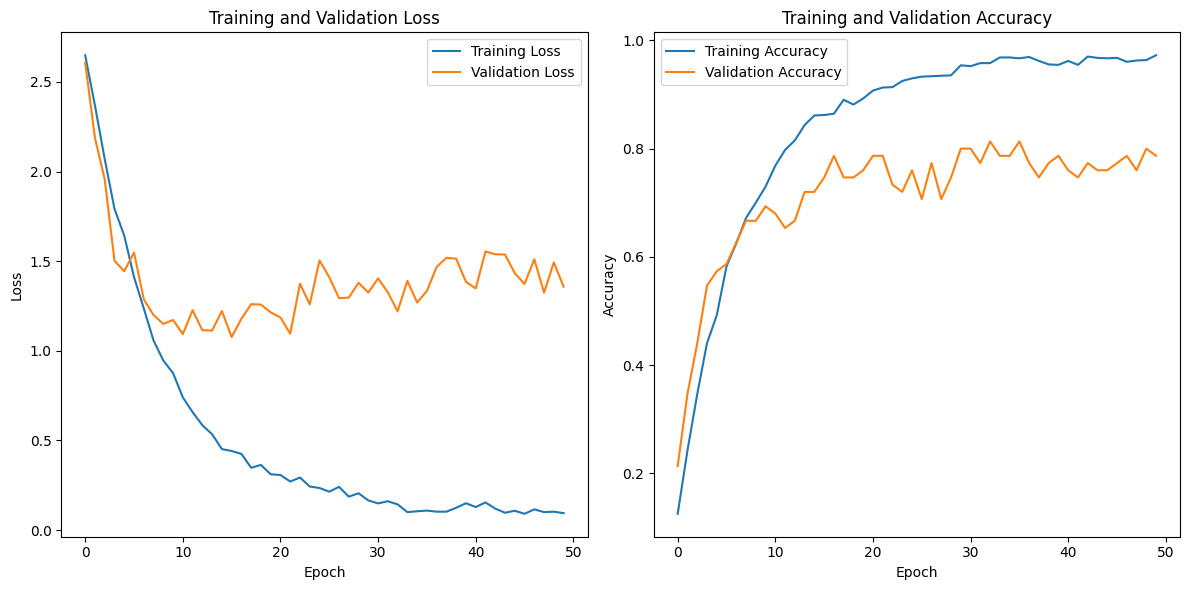

In [29]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res.history['loss'], label='Training Loss')
plt.plot(res.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res.history['accuracy'], label='Training Accuracy')
plt.plot(res.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 1st attempt 

No gráfico da Accuracy podemos ver que existe um gap entre a linha do treino e da validation, ou seja, como a accuracy do treino está muito acima do teste, podemos concluir que o modelo está em overfitting. 
No gráfico da Loss existe também um gap entre as duas linhas, sendo que após algumas Epochs a validação começa a aumentar, ou seja, o modelo esta se a ajustar demasiado aos dados de treino perdendo capacidade de generalizar.



## Attempt 2

### Image Augmentation
* **target_size (128, 128)**
* batch_size (32)

### CNN Architecture
* Step 1: 1st convolutional layer:
  * **shape (128, 128, 3)**;
  * filters (32);
  * kernel_size (3);
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * activation function (Relu);
  * max pooling (pool_size =2, stride =2);
  * dropout (0.25);
* Step 4: Flattening
* Step 5: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * **dropout (0.30)**;
* Step 6: output layer:
  * units (15);
  * activation function (softmax).
* Step 7: Optimizer:
  * Adam;
  * **Learning_rate (0.0005)**.

**Epochs: 40**

**Para diminuir o overfitting e procurar uma melhor convergencia, estabilizando a aprendizagem, diminuimos a learning_rate para 0.0005.**

In [30]:
train_datagen2 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set2 = train_datagen2.flow_from_directory('train_set',
                                                 target_size = (128, 128), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen2 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set2 = test_datagen2.flow_from_directory('test_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn2 = tf.keras.models.Sequential()

cnn2.add(tf.keras.layers.Input(shape=[128, 128, 3]))
cnn2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn2.add(tf.keras.layers.Dropout(0.25))

cnn2.add(tf.keras.layers.Flatten())

cnn2.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn2.add(tf.keras.layers.Dropout(0.25))
cnn2.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn2.add(tf.keras.layers.Dropout(0.30))

cnn2.add(tf.keras.layers.Dense(units=15, activation='softmax'))

# Visualize the CNN
cnn2.summary()

cnn2.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy']) 

res2 = cnn2.fit(x = training_set2, validation_data = test_set2, epochs = 40)


Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,834,895 (56.59 MB)

 Trainable params: 14,834,895 (56.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step - accuracy: 0.0982 - loss: 2.7824 - val_accuracy: 0.2400 - val_loss: 2.4288
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.2138 - loss: 2.4648 - val_accuracy: 0.3600 - val_loss: 2.0027
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.3677 - loss: 2.1313 - val_accuracy: 0.4533 - val_loss: 1.6891
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - accuracy: 0.4415 - loss: 1.8131 - val_accuracy: 0.5467 - val_loss: 1.5184
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.5124 - loss: 1.5666 - val_accuracy: 0.5600 - val_loss: 1.3593
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.5718 - loss: 1.4324 - val_accuracy: 0.5867 - val_loss: 1.2710
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.6128 - loss: 1.3055 - val_accuracy: 0.6533 - val_loss: 1.1646
Epoch 8/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.6239 - loss: 1.1931 - val_accu

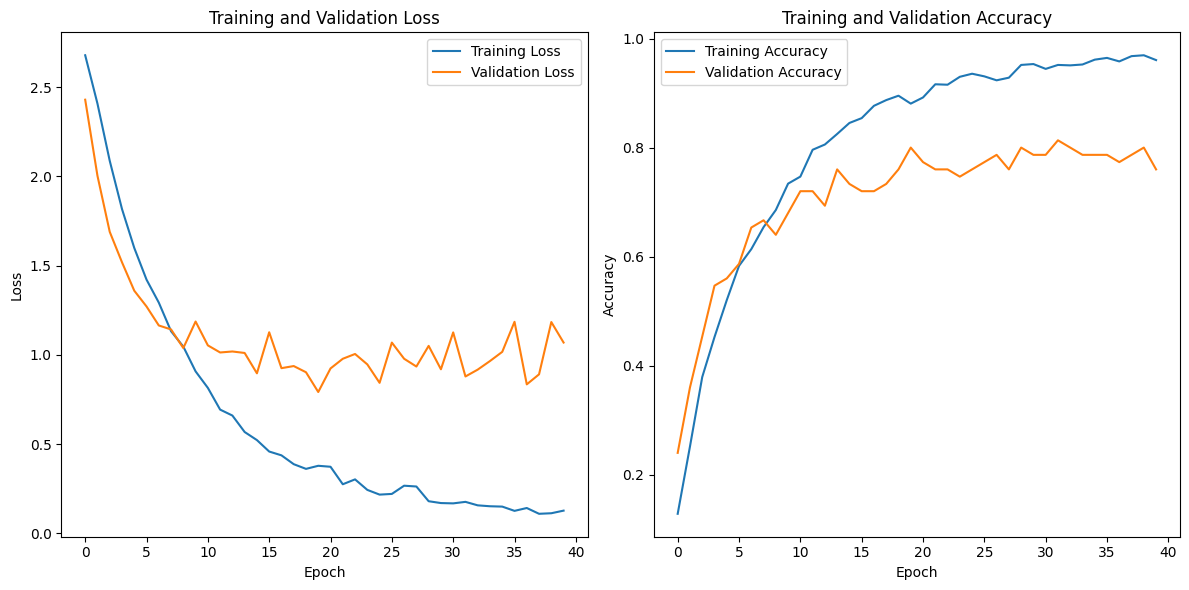

In [32]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res2.history['loss'], label='Training Loss')
plt.plot(res2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res2.history['accuracy'], label='Training Accuracy')
plt.plot(res2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Conclusion 2nd attempt 

No gráfico da Accuracy e no da Loss podemos ver que o gap ficou mais pequeno, o que mostra que houve uma diminuição do overfitting, no entanto a sua presença ainda é bastante notória.

## Attempt 3

### Image Augmentation
* target_size (128, 128)
* batch_size (32)

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (128, 128, 3);
  * filters (32);
  * kernel_size (3);
  * activation function (Relu);
  * **L2 regularization (0.001)**;
* Step 2: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * activation function (Relu);
  * **L2 regularization (0.001)**;
  * max pooling (pool_size =2, stride =2);
  * dropout (0.25);
* Step 4: Flattening
* Step 5: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.001)**;
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.001)**;
  * dropout (0.30);
* Step 6: output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0005).

Epochs: 40

**Para diminuir o overfitting usamos técnicas de regularização L2.**

In [32]:
train_datagen3 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set3 = train_datagen3.flow_from_directory('train_set',
                                                 target_size = (128, 128), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen3 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set3 = test_datagen3.flow_from_directory('test_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')


cnn3 = tf.keras.models.Sequential()
cnn3.add(tf.keras.layers.Input(shape=[128, 128, 3]))
cnn3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn3.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn3.add(tf.keras.layers.Dropout(0.25))

cnn3.add(tf.keras.layers.Flatten())

cnn3.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
cnn3.add(tf.keras.layers.Dropout(0.25))
cnn3.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
cnn3.add(tf.keras.layers.Dropout(0.30))


cnn3.add(tf.keras.layers.Dense(units=15, activation='softmax'))

cnn3.compile(optimizer=Adam(learning_rate=0.0005),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

res3 = cnn3.fit(x=training_set3, validation_data=test_set3, epochs=40)


Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Epoch 1/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.0923 - loss: 3.5810 - val_accuracy: 0.1867 - val_loss: 2.9662
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step - accuracy: 0.2164 - loss: 2.9956 - val_accuracy: 0.3467 - val_loss: 2.6664
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.3367 - loss: 2.6118 - val_accuracy: 0.4133 - val_loss: 2.2086
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.4404 - loss: 2.3288 - val_accuracy: 0.5200 - val_loss: 2.1127
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.4852 - loss: 2.1007 - val_accuracy: 0.5333 - val_loss: 2.0247
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.5500 - loss: 1.9702 - val_accuracy: 0.5600 - val_loss: 1.8943
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 284ms/step - accuracy: 0.5808 - loss: 1.8483 - val_accuracy: 0.6800 - val_loss: 1.8478
Epoch 8/40
39

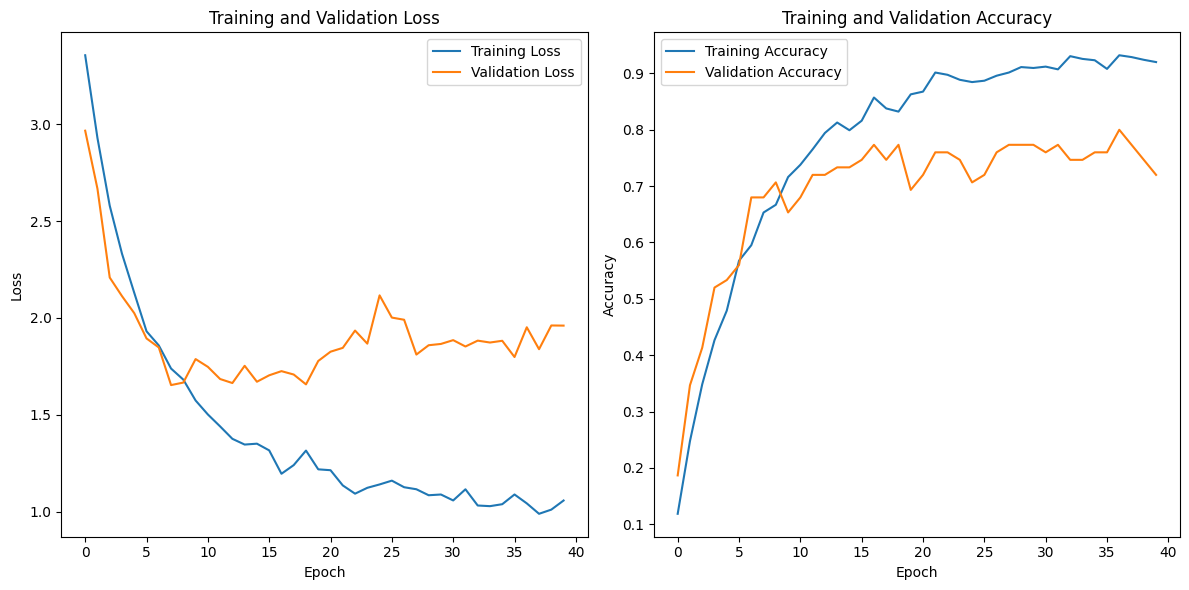

In [33]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res3.history['loss'], label='Training Loss')
plt.plot(res3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res3.history['accuracy'], label='Training Accuracy')
plt.plot(res3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 3rd attempt 

No gráfico da Accuracy e no da Loss podemos ver que o gap ficou novamente mais pequeno, o que mostra que houve uma diminuição do overfiting, no entanto a sua presença ainda é bastante notória. Para além disso, a loss function parece ter perdido alguma capacidade, não baixando de 1.0. 

## Attempt 4

### Image Augmentation
* target_size (128, 128)
* batch_size (32)

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (128, 128, 3);
  * **filters (64)**;
  * kernel_size (3);
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * **filters (128)**;
  * kernel_size (3);
  * activation function (Relu);
  * max pooling (pool_size =2, stride =2);
  * dropout (0.25);
* Step 4: Flattening
* Step 5: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.03)**;
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.03)**;
  * dropout (0.30);
* Step 6: output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0005); 
  * **weight_decay (0.03)**.

**Epochs: 100**

**Retiramos as L2 da 1st e 2nd convulutional layer, aumentando os restantes valores de regularização para 0.003. Foi também aplicado um aumento de filtros nas covolutional layers**

In [7]:
train_datagen4 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set4 = train_datagen4.flow_from_directory('train_set',
                                                 target_size = (128, 128), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen4 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set4 = test_datagen4.flow_from_directory('test_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')


cnn4 = tf.keras.models.Sequential()
cnn4.add(tf.keras.layers.Input(shape=[128, 128, 3]))
cnn4.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn4.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn4.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn4.add(tf.keras.layers.Dropout(0.25))

cnn4.add(tf.keras.layers.Flatten())

cnn4.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
cnn4.add(tf.keras.layers.Dropout(0.25))
cnn4.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
cnn4.add(tf.keras.layers.Dropout(0.30))

cnn4.add(tf.keras.layers.Dense(units=15, activation='softmax'))

cnn4.compile(optimizer=Adam(learning_rate=0.0005, weight_decay=0.03),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

res4 = cnn4.fit(x=training_set4, validation_data=test_set4, epochs=100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 419ms/step - accuracy: 0.1070 - loss: 16.6538 - val_accuracy: 0.1600 - val_loss: 8.0767
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step - accuracy: 0.2000 - loss: 7.4798 - val_accuracy: 0.2400 - val_loss: 6.0065
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.2664 - loss: 5.8005 - val_accuracy: 0.4000 - val_loss: 4.8751
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 356ms/step - accuracy: 0.3223 - loss: 4.8923 - val_accuracy: 0.4533 - val_loss: 4.2587
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 365ms/step - accuracy: 0.3299 - loss: 4.3976 - val_accuracy: 0.3733 - val_loss: 3.7559
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.3915 - loss: 3.8534 - val_accuracy: 0.4533 - val_loss: 3.5034
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 348ms/step - accuracy: 0.4139 - loss: 3.6647 - val_accuracy: 0.4800 - val_loss: 3.3586
Epoch

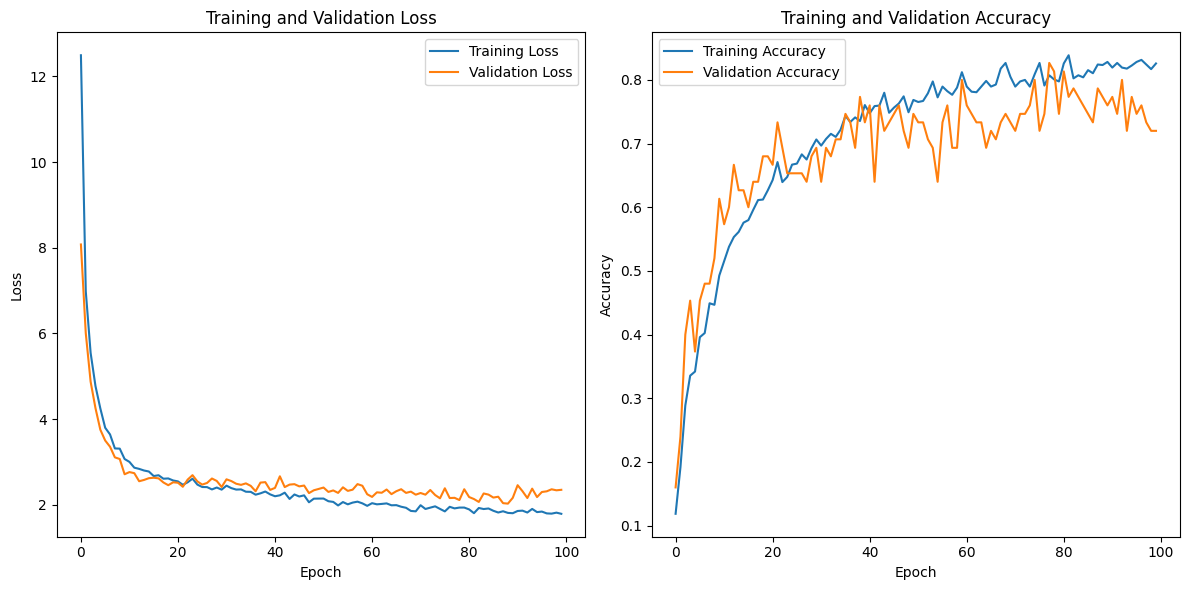

In [9]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res4.history['loss'], label='Training Loss')
plt.plot(res4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res4.history['accuracy'], label='Training Accuracy')
plt.plot(res4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 4th attempt 

De um modo geral, podemos ver que houve grandes alterações em ambos os gráficos. No gráfico da Accuracy o gap entre as duas linhas diminuiu drasticamente, no entanto ocorreu exploding gradient. Já no gráfico da Loss podemos ver que existe uma atenuação de ambas as linhas, ainda que estas se mantenham um pouco instáveis e com valores mais altos do que os pretendidos.

## Attempt 5

### Image Augmentation
* **target_size (64, 64)**
* batch_size (32)

### CNN Architecture
* Step 1: 1st convolutional layer:
  * **shape (64, 64, 3)**;
  * **filters (32)**;
  * **kernel_size (5)**;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * **pool_size = 5**;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * **filters (64)**;
  * kernel_size (3);
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.05)**;
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.05)**;
  * dropout (0.30);
* Step 7: output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0005); 
  * **weight_decay (0.05)**.

**Epochs: 50**

**Foi realizada uma redução no tamanho das imagens. Para além disso foi aplicada a regularização L2 apenas nos fully connected layers e o valor desta e do weight decay foram aumentados para 0.05**

In [10]:
train_datagen8 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set8 = train_datagen8.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen8 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set8 = test_datagen8.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn8 = tf.keras.models.Sequential()

cnn8.add(tf.keras.layers.Input(shape=[64, 64, 3]))
cnn8.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'))


cnn8.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn8.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn8.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn8.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn8.add(tf.keras.layers.Flatten())



cnn8.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.05)))
cnn8.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%
cnn8.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.05)))
cnn8.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn8.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn8.summary()


cnn8.compile(optimizer=Adam(learning_rate=0.0005, weight_decay=0.05), loss='categorical_crossentropy', metrics=['accuracy'])


res8 = cnn8.fit(x = training_set8, validation_data = test_set8, epochs = 50)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.0883 - loss: 29.5095 - val_accuracy: 0.1600 - val_loss: 11.4442
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.1420 - loss: 9.8949 - val_accuracy: 0.2800 - val_loss: 6.8125
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.2031 - loss: 6.3292 - val_accuracy: 0.3200 - val_loss: 4.8212
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.2686 - loss: 4.6866 - val_accuracy: 0.3200 - val_loss: 3.8964
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.2743 - loss: 3.8382 - val_accuracy: 0.2933 - val_loss: 3.3148
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.2688 - loss: 3.3329 - val_accuracy: 0.4800 - val_loss: 2.7318
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.3050 - loss: 2.9731 - val_accuracy: 0.4267 - val_loss: 2.5561
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.3256 - loss: 2.7632 - val_accuracy: 0.4533 - v

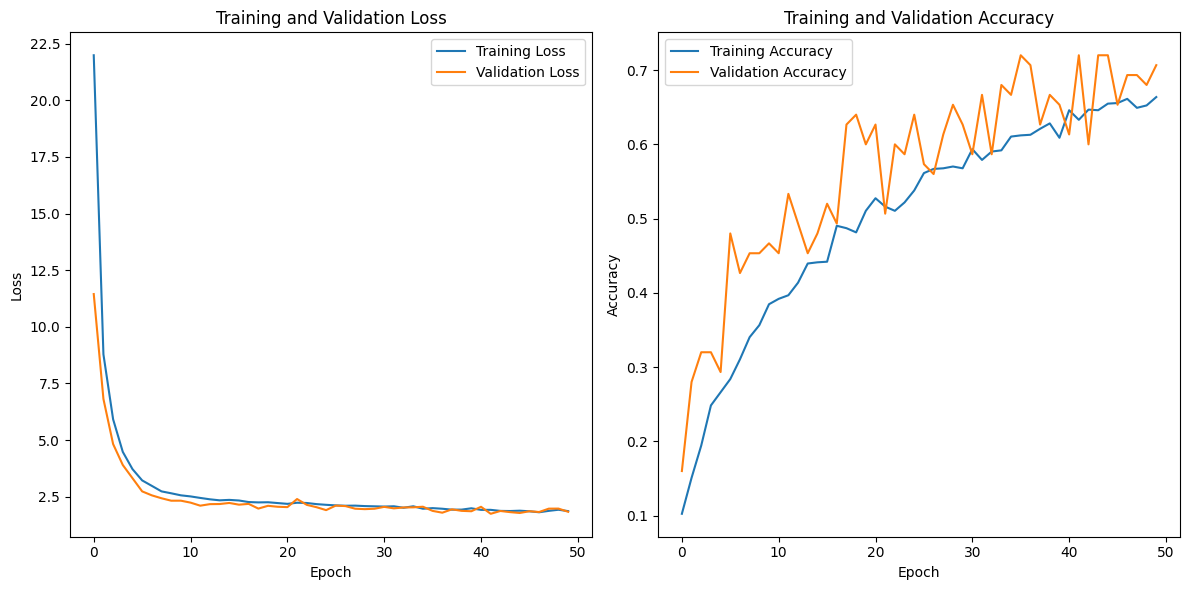

In [11]:
from matplotlib import pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res8.history['loss'], label='Training Loss')
plt.plot(res8.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res8.history['accuracy'], label='Training Accuracy')
plt.plot(res8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 5th attempt 

Estes resultados mostram um aumento na estabilidade do comportamento da loss function, sublinhando que o exploding gradient se manteve.

## Attempt 6

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.03)**;
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * **L2 regularization (0.03)**;
  * dropout (0.30);
* Step 7: output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0005); 
  * **weight_decay (0.03)**.

**Epochs: 50**

**A regularização L2 e do weight decay foram reduzidas novamente para 0.03**

In [12]:
train_datagen9 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set9 = train_datagen9.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen9 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set9 = test_datagen9.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn9 = tf.keras.models.Sequential()

cnn9.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn9.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'))
cnn9.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn9.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn9.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn9.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn9.add(tf.keras.layers.Flatten())


cnn9.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
cnn9.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%
cnn9.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
cnn9.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn9.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn9.summary()


cnn9.compile(optimizer=Adam(learning_rate=0.0005, weight_decay=0.03), loss='categorical_crossentropy', metrics=['accuracy'])


res9 = cnn9.fit(x = training_set9, validation_data = test_set9, epochs = 50)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.0966 - loss: 19.2901 - val_accuracy: 0.1467 - val_loss: 8.5322
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.1359 - loss: 7.5074 - val_accuracy: 0.2267 - val_loss: 5.4015
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.2304 - loss: 5.0952 - val_accuracy: 0.2800 - val_loss: 4.1517
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.2858 - loss: 4.0312 - val_accuracy: 0.3067 - val_loss: 3.4642
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.3097 - loss: 3.4611 - val_accuracy: 0.3867 - val_loss: 3.0640
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.3417 - loss: 3.1248 - val_accuracy: 0.4400 - val_loss: 2.8057
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.3609 - loss: 2.8623 - val_accuracy: 0.4000 - val_loss: 2.5166
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.4140 - loss: 2.6871 - val_accuracy:

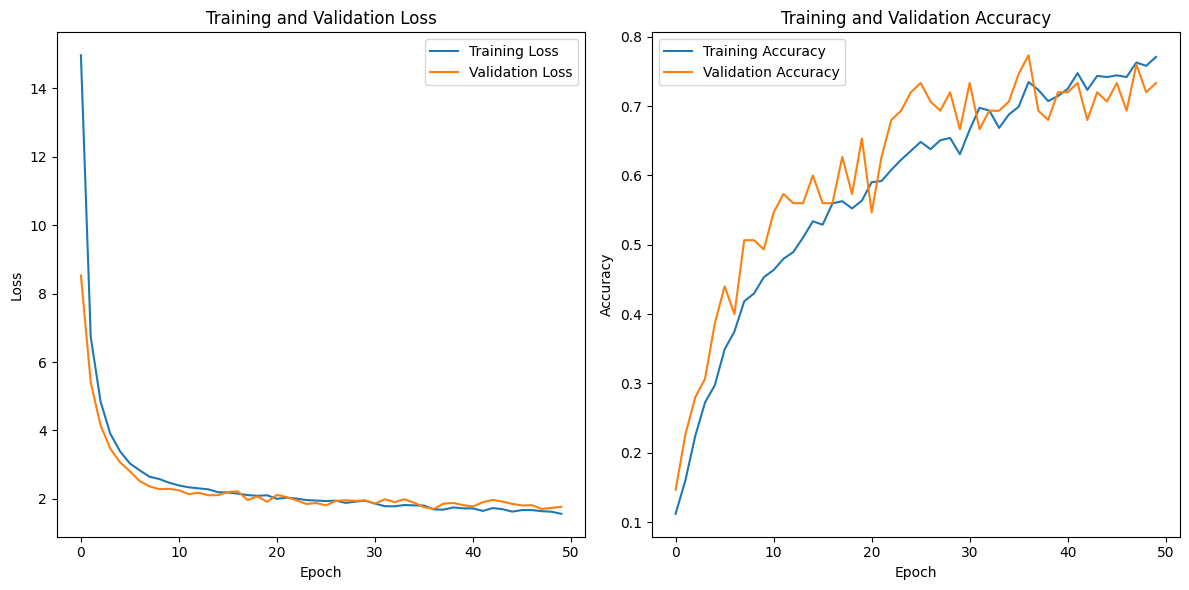

In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res9.history['loss'], label='Training Loss')
plt.plot(res9.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res9.history['accuracy'], label='Training Accuracy')
plt.plot(res9.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 6th attempt 

È notável a redução do exploding gradient e a loss function atingiu valores mais reduzidos.

## Attempt 7

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * dropout (0.30);
* Step 7: output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * **Learning_rate (0.0001)**; 
  * weight_decay (0.03).

**Epochs: 100**

**A Learning Rate foi reduzida para 0.0001**

In [14]:
train_datagen10 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set10 = train_datagen10.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen10 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set10 = test_datagen10.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn10 = tf.keras.models.Sequential()

cnn10.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn10.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'))
cnn10.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn10.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn10.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn10.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn10.add(tf.keras.layers.Flatten())


cnn10.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
cnn10.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%
cnn10.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03)))
cnn10.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn10.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn10.summary()


cnn10.compile(optimizer=Adam(learning_rate=0.0001, weight_decay=0.03), loss='categorical_crossentropy', metrics=['accuracy'])


res10 = cnn10.fit(x = training_set10, validation_data = test_set10, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.0738 - loss: 23.8195 - val_accuracy: 0.1600 - val_loss: 19.5260
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.1056 - loss: 18.3698 - val_accuracy: 0.1200 - val_loss: 15.3451
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.1275 - loss: 14.5614 - val_accuracy: 0.2133 - val_loss: 12.4302
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.1755 - loss: 11.9151 - val_accuracy: 0.3067 - val_loss: 10.3915
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.1943 - loss: 10.0948 - val_accuracy: 0.2533 - val_loss: 9.0227
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.2176 - loss: 8.8352 - val_accuracy: 0.3467 - val_loss: 7.8909
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.2521 - loss: 7.8312 - val_accuracy: 0.3467 - val_loss: 7.1151
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.3032 - loss: 7.0650 

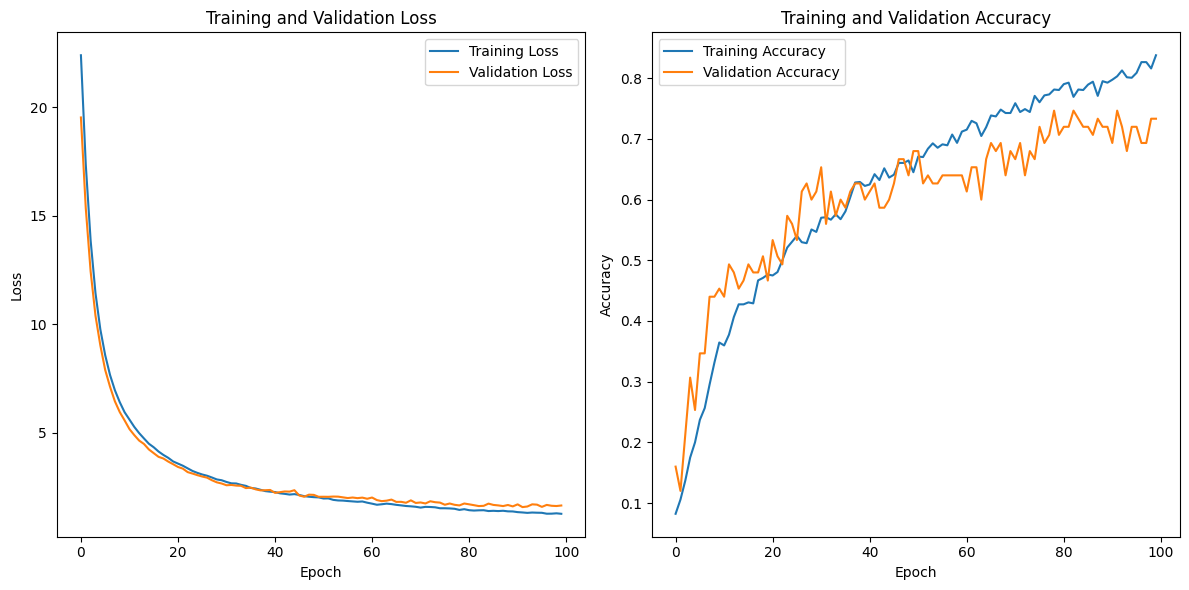

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res10.history['loss'], label='Training Loss')
plt.plot(res10.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res10.history['accuracy'], label='Training Accuracy')
plt.plot(res10.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 7th attempt 

Apesar desta alteração o gradiente parece ainda muito instável e o overfitting mantém-se. Desta vez é possível notar que o valor inicial da loss function é bastante mais alto do que o anterior, ainda que tenha atingido um valor final semelhante.

## Attempt 8

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * **He Initializer**
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * **He Initializer**:
  * dropout (0.30);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0001); 
  * weight_decay (0.03);
  * **clipnorm (1.0)**;

**Epochs: 100**

**Foi adicionado um algoritmo de inicialização de weights - He Initialization nas fully connected layers. Para além disso, foi adicionado clipnorm ao otimizador de weights**

In [16]:
train_datagen11 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set11 = train_datagen11.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen11 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set11 = test_datagen11.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn11 = tf.keras.models.Sequential()

cnn11.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn11.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn11.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn11.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn11.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn11.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn11.add(tf.keras.layers.Flatten())


cnn11.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn11.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%
cnn11.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn11.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn11.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn11.summary()


cnn11.compile(optimizer=Adam(learning_rate=0.0001, weight_decay=0.03, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])


res11 = cnn11.fit(x = training_set11, validation_data = test_set11, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.0662 - loss: 33.1997 - val_accuracy: 0.1067 - val_loss: 29.0905
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.1020 - loss: 27.9739 - val_accuracy: 0.2267 - val_loss: 24.5966
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.1135 - loss: 23.8086 - val_accuracy: 0.2267 - val_loss: 21.3670
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.1522 - loss: 20.8745 - val_accuracy: 0.1733 - val_loss: 19.0444
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.1902 - loss: 18.6184 - val_accuracy: 0.3067 - val_loss: 17.1848
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.2250 - loss: 16.9525 - val_accuracy: 0.3867 - val_loss: 15.6987
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.2637 - loss: 15.5467 - val_accuracy: 0.3600 - val_loss: 14.4935
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.3123 - loss: 14

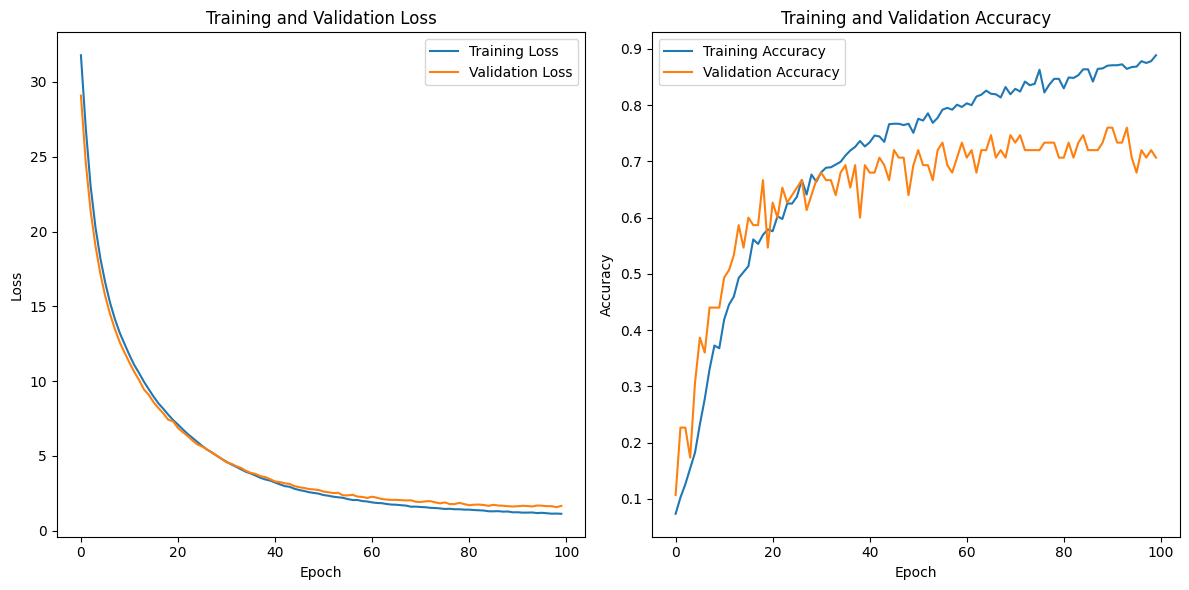

In [17]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res11.history['loss'], label='Training Loss')
plt.plot(res11.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res11.history['accuracy'], label='Training Accuracy')
plt.plot(res11.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 8th attempt 

Este modelo apresenta uma redução significativa na loss function, de forma estável ainda que o overfitting se mantenha. Apesar disso, a accuracy parece ter um acompanhamento de treino e validação razoavelmente estável até aos 65%.

## Attempt 9

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * **BatchNormalization**;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * **BatchNormalization**;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * dropout (0.25);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.30);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0001); 
  * weight_decay (0.03);
  * clipnorm (1.0);

**Epochs: 100**

**Foi aplicada normalização através do BatchNormalization nas convolutional layers**

In [18]:
train_datagen12 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set12 = train_datagen12.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen12 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set12 = test_datagen12.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn12 = tf.keras.models.Sequential()

cnn12.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn12.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, kernel_initializer=HeNormal()))
cnn12.add(tf.keras.layers.BatchNormalization())  # Added Batch Normalization
cnn12.add(tf.keras.layers.Activation('relu'))
cnn12.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn12.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, kernel_initializer=HeNormal()))
cnn12.add(tf.keras.layers.BatchNormalization())  # Added Batch Normalization
cnn12.add(tf.keras.layers.Activation('relu'))
cnn12.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn12.add(tf.keras.layers.Dropout(0.25))


cnn12.add(tf.keras.layers.Flatten())


# First Dense Block
cnn12.add(tf.keras.layers.Dense(units=256, kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn12.add(tf.keras.layers.Activation('relu'))
cnn12.add(tf.keras.layers.Dropout(0.25))

# Second Dense Block
cnn12.add(tf.keras.layers.Dense(units=256, kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn12.add(tf.keras.layers.Activation('relu'))
cnn12.add(tf.keras.layers.Dropout(0.30))



#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn12.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn12.summary()


cnn12.compile(optimizer=Adam(learning_rate=0.0001, weight_decay=0.03, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])


res12 = cnn12.fit(x = training_set12, validation_data = test_set12, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,860,111 (10.91 MB)

 Trainable params: 2,859,919 (10.91 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - accuracy: 0.0953 - loss: 33.6302 - val_accuracy: 0.1600 - val_loss: 31.4436
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.1642 - loss: 30.8465 - val_accuracy: 0.2667 - val_loss: 28.9513
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.2493 - loss: 28.3668 - val_accuracy: 0.4133 - val_loss: 26.6673
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.2986 - loss: 26.1984 - val_accuracy: 0.3867 - val_loss: 24.5952
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.3372 - loss: 24.2022 - val_accuracy: 0.4000 - val_loss: 22.8398
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.3545 - loss: 22.5415 - val_accuracy: 0.4667 - val_loss: 21.2117
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.4068 - loss: 20.8804 - val_accuracy: 0.4533 - val_loss: 19.7063
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.4344 - los

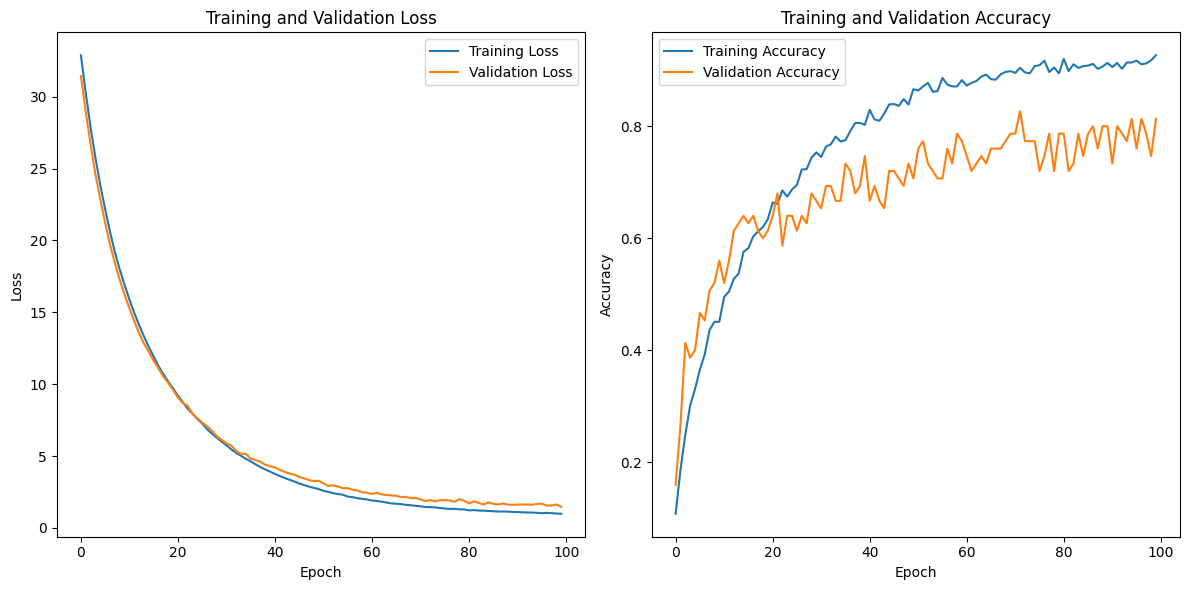

In [19]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res12.history['loss'], label='Training Loss')
plt.plot(res12.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res12.history['accuracy'], label='Training Accuracy')
plt.plot(res12.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 9th attempt 

As alterações não resultaram em melhorias significativas. Pelo contrário, a loss function apresenta um gap maior a partir de 5.0.

## Attempt 10

### Data Augmentation
* **rotation_range=20**;
* **width_shift_range=0.2**;
* **height_shift_range=0.2**;
* **fill_mode='nearest'**.

### CNN Architecture
* Step 1: 1st covulutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * **dropout (0.35)**;
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * **dropout (0.40)**;
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0001); 
  * weight_decay (0.03);
  * clipnorm (1.0);

**Epochs: 100**

**Foi aplicado um dropout mais elevado. Para além disso, foi realizada data augmentation com mais parâmetros**

In [20]:
train_datagen13 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True, # flip
                                   rotation_range=20,  # rotate images by up to 20 degrees
                                   width_shift_range=0.2,  # shift width by up to 20%
                                   height_shift_range=0.2,  # shift height by up to 20%
                                   fill_mode='nearest'  # Fill missing pixels
                                   )

# apply the augmentation considering our original train images
training_set13 = train_datagen13.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen13 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set13 = test_datagen13.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn13 = tf.keras.models.Sequential()

cnn13.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn13.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, kernel_initializer=HeNormal()))
cnn13.add(tf.keras.layers.BatchNormalization())  # Added Batch Normalization
cnn13.add(tf.keras.layers.Activation('relu'))
cnn13.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn13.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, kernel_initializer=HeNormal()))
cnn13.add(tf.keras.layers.BatchNormalization())  # Added Batch Normalization
cnn13.add(tf.keras.layers.Activation('relu'))
cnn13.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn13.add(tf.keras.layers.Dropout(0.25))


cnn13.add(tf.keras.layers.Flatten())


# First Dense Block
cnn13.add(tf.keras.layers.Dense(units=256, kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn13.add(tf.keras.layers.Activation('relu'))
cnn13.add(tf.keras.layers.Dropout(0.35))

# Second Dense Block
cnn13.add(tf.keras.layers.Dense(units=256, kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn13.add(tf.keras.layers.Activation('relu'))
cnn13.add(tf.keras.layers.Dropout(0.40))



#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn13.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn13.summary()


cnn13.compile(optimizer=Adam(learning_rate=0.0001, weight_decay=0.03, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])


res13 = cnn13.fit(x = training_set13, validation_data = test_set13, epochs = 50)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,860,111 (10.91 MB)

 Trainable params: 2,859,919 (10.91 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 260ms/step - accuracy: 0.0732 - loss: 33.8280 - val_accuracy: 0.1333 - val_loss: 31.5889
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.0845 - loss: 31.0359 - val_accuracy: 0.1867 - val_loss: 28.7396
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.1217 - loss: 27.9915 - val_accuracy: 0.1600 - val_loss: 25.8647
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.1497 - loss: 25.2121 - val_accuracy: 0.1733 - val_loss: 23.3648
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.1466 - loss: 22.8335 - val_accuracy: 0.2133 - val_loss: 21.1291
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step - accuracy: 0.1506 - loss: 20.7778 - val_accuracy: 0.2000 - val_loss: 19.2593
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.1523 - loss: 18.9012 - val_accuracy: 0.2000 - val_loss: 17.5185
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.1620 - loss: 17.

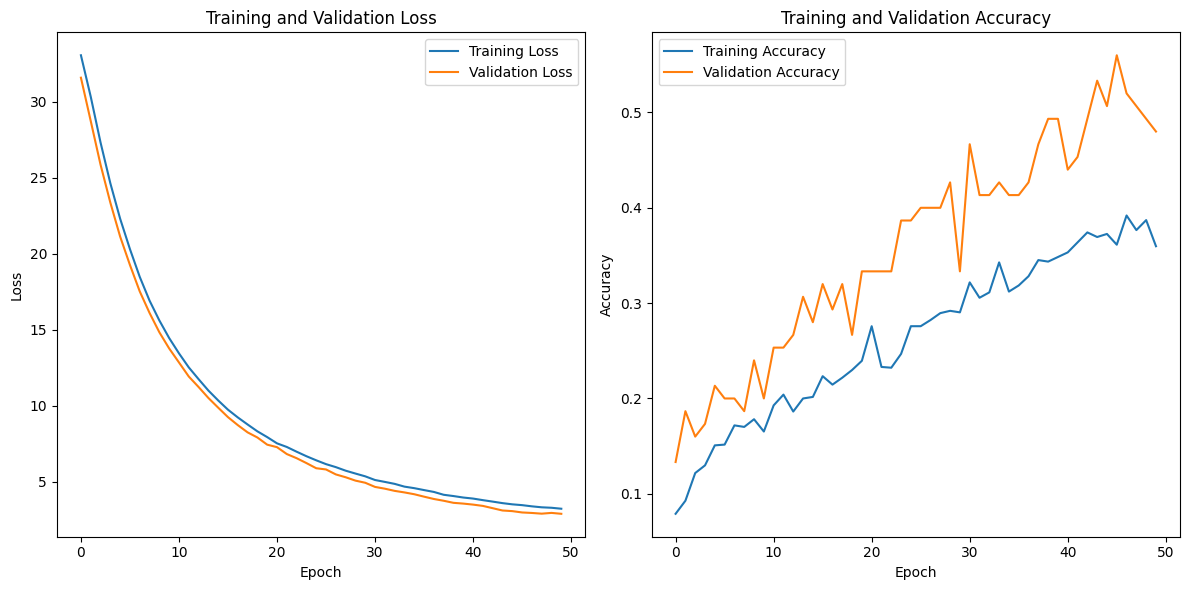

In [21]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res13.history['loss'], label='Training Loss')
plt.plot(res13.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res13.history['accuracy'], label='Training Accuracy')
plt.plot(res13.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 10th attempt 

Pelos gráficos é possível notar uma redução na aprendizagem do modelo, visto que a curva e accuracy apresenta uma subida muito mais lenta do que os modelos anteriores. Seria de esperar uma subida mais rápida.

## Attempt 11

### Data Augmentation
* **eliminated rotation_range=20**;
* **eliminated width_shift_range=0.2**;
* **eliminated height_shift_range=0.2**;
* **eliminated fill_mode='nearest'**.

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * **dropout (0.30)**;
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.40);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * Adam;
  * Learning_rate (0.0001); 
  * weight_decay (0.03);
  * clipnorm (1.0);

**Epochs: 100**

**Foi eliminadas as alterações anteriores relativamente à data augmentation. Reduzido o valor de dropout do primeiro fully connected layer**

In [22]:
train_datagen14 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set14 = train_datagen14.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen14 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set14 = test_datagen14.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn14 = tf.keras.models.Sequential()

cnn14.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn14.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn14.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn14.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn14.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn14.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn14.add(tf.keras.layers.Flatten())


cnn14.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn14.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%
cnn14.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn14.add(tf.keras.layers.Dropout(0.40))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn14.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn14.summary()


cnn14.compile(optimizer=Adam(learning_rate=0.0001, weight_decay=0.03, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])


res14 = cnn14.fit(x = training_set14, validation_data = test_set14, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.0669 - loss: 33.1060 - val_accuracy: 0.1200 - val_loss: 29.4203
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.0905 - loss: 28.4148 - val_accuracy: 0.2267 - val_loss: 25.1469
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.1303 - loss: 24.2974 - val_accuracy: 0.1867 - val_loss: 21.6726
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.1345 - loss: 21.1406 - val_accuracy: 0.2133 - val_loss: 19.2842
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.1846 - loss: 18.8561 - val_accuracy: 0.3333 - val_loss: 17.4077
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.2242 - loss: 17.1325 - val_accuracy: 0.3867 - val_loss: 15.9950
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.2825 - loss: 15.7546 - val_accuracy: 0.4400 - val_loss: 14.7709
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.3146 - los

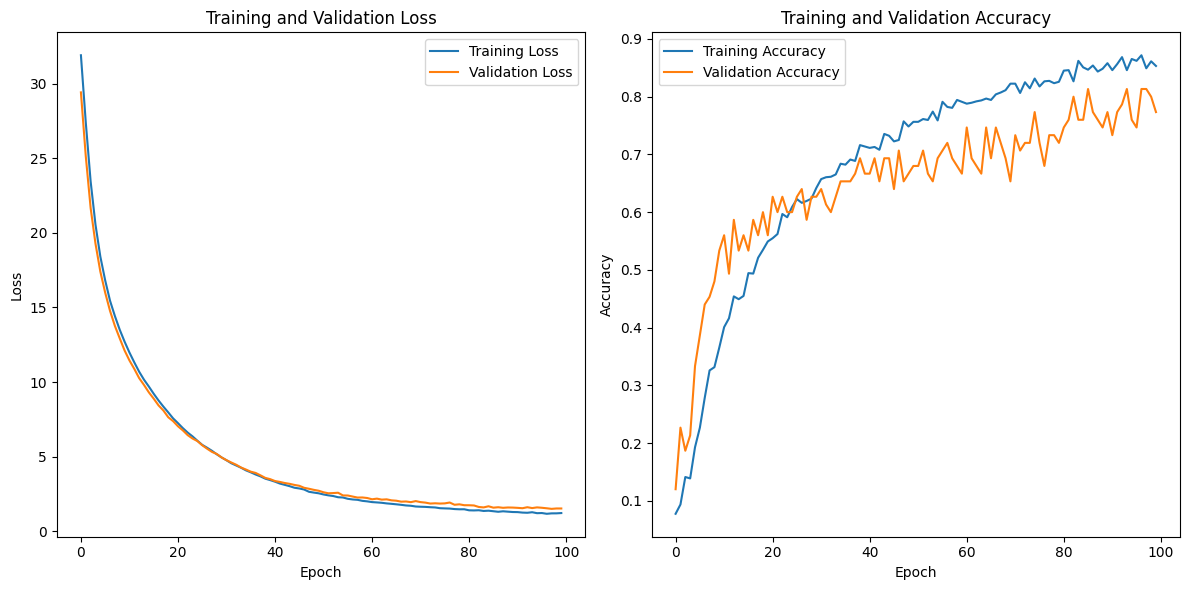

In [23]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res14.history['loss'], label='Training Loss')
plt.plot(res14.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res14.history['accuracy'], label='Training Accuracy')
plt.plot(res14.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 11th attempt 

Desta vez o modelo voltou a apresentar comportamentos mais positivos, sendo que ainda é possível reconhecer overfitting. Este modelo continua sem ultrapassar a accuracy de 70% na validação.

## Attempt 12

### CNN Architecture
* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Fully connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * dropout (0.30);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.40);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * **SGD**;
  * **Learning_rate (0.001)**; 
  * **eliminated weight_decay (0.03)**;
  * **momentum (0.9)**;

**Epochs: 100**

**Alterado o otimizador para SGD (Stochastic Gradient Descent).**

In [24]:
train_datagen15 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set15 = train_datagen15.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen15 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set15 = test_datagen15.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn15 = tf.keras.models.Sequential()

cnn15.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn15.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn15.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn15.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn15.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn15.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn15.add(tf.keras.layers.Flatten())


cnn15.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn15.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%
cnn15.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn15.add(tf.keras.layers.Dropout(0.40))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn15.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn15.summary()


cnn15.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])

res15 = cnn15.fit(x = training_set15, validation_data = test_set15, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.0819 - loss: 33.7684 - val_accuracy: 0.1067 - val_loss: 32.3917
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.1021 - loss: 32.0396 - val_accuracy: 0.1467 - val_loss: 30.9792
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.1485 - loss: 30.6584 - val_accuracy: 0.2267 - val_loss: 29.6004
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.1514 - loss: 29.3212 - val_accuracy: 0.2133 - val_loss: 28.2469
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.1591 - loss: 28.0361 - val_accuracy: 0.2400 - val_loss: 26.9690
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.2023 - loss: 26.7712 - val_accuracy: 0.3600 - val_loss: 25.7818
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.2417 - loss: 25.5966 - val_accuracy: 0.3733 - val_loss: 24.6125
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.2546 - loss: 24

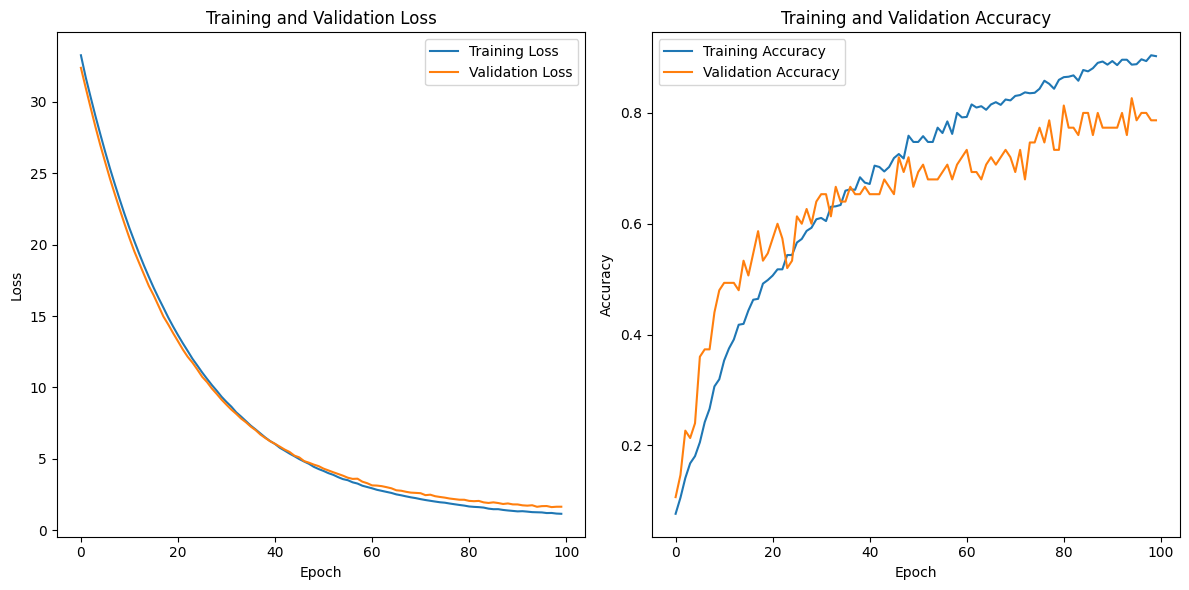

In [25]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res15.history['loss'], label='Training Loss')
plt.plot(res15.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res15.history['accuracy'], label='Training Accuracy')
plt.plot(res15.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 12th attempt 

Com este otimizador o modelo não apresentou alterações significativamente distintas dos anteriores.

## Attempt 13

### CNN Architecture

* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * dropout (0.30);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.40);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * **RMSprop**;
  * Learning_rate (0.001); 
  * **rho (0.9)**;
  * **momentum (0.0)**;

**Epochs: 100**

**Alterado o otimizador para RMSprop.**

In [26]:
train_datagen16 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set16 = train_datagen16.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen16 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set16 = test_datagen16.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn16 = tf.keras.models.Sequential()

cnn16.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn16.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn16.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn16.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn16.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn16.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn16.add(tf.keras.layers.Flatten())


cnn16.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn16.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%
cnn16.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn16.add(tf.keras.layers.Dropout(0.40))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn16.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn16.summary()


cnn16.compile(optimizer=RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0), loss='categorical_crossentropy', metrics=['accuracy'])

res16 = cnn16.fit(x = training_set16, validation_data = test_set16, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.0996 - loss: 27.6647 - val_accuracy: 0.2533 - val_loss: 13.2235
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.1784 - loss: 11.4202 - val_accuracy: 0.1467 - val_loss: 7.5749
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.2169 - loss: 6.5366 - val_accuracy: 0.3600 - val_loss: 4.8998
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.2931 - loss: 4.5344 - val_accuracy: 0.2667 - val_loss: 3.6791
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.3169 - loss: 3.6221 - val_accuracy: 0.3733 - val_loss: 3.0654
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.3290 - loss: 3.1294 - val_accuracy: 0.4267 - val_loss: 2.7127
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.3954 - loss: 2.8261 - val_accuracy: 0.4533 - val_loss: 2.6145
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.4120 - loss: 2.6277 - val_

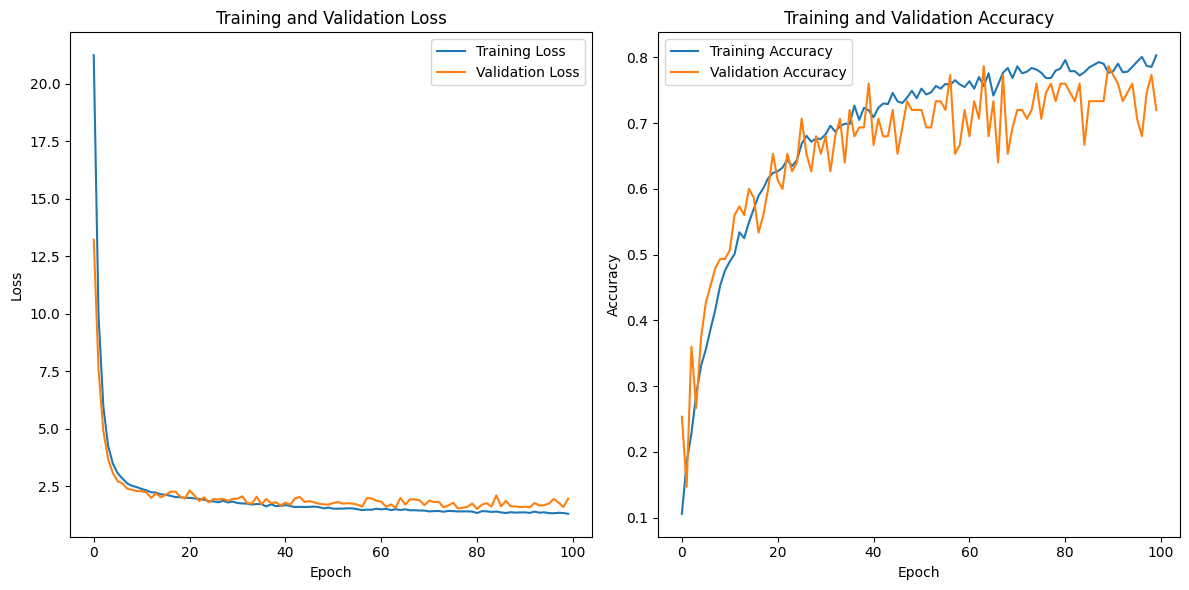

In [27]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res16.history['loss'], label='Training Loss')
plt.plot(res16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res16.history['accuracy'], label='Training Accuracy')
plt.plot(res16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 13rd attempt 

Este otimizador apresenta uma loss curve mais instável e com valores mais elevados. Apesar disso, a accuracy foi capaz de atingir os valores medidos nos modelos anteriores, ainda que com exploding gradient mais acentuado.

## Attempt 14

### CNN Architecture

* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * dropout (0.30);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.40);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * **AdamW**;
  * **Learning_rate (0.0001)**; 
  * **weight_decay (0.03)**;
  * **eliminated rho (0.9)**;
  * **eliminated momentum (0.0)**;

**Epochs: 100**

**Alterado o otimizador para AdamW.**

In [5]:
train_datagen17 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set17 = train_datagen17.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen17 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set17 = test_datagen17.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn17 = tf.keras.models.Sequential()

cnn17.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn17.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn17.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn17.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn17.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn17.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn17.add(tf.keras.layers.Flatten())


cnn17.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn17.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%
cnn17.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn17.add(tf.keras.layers.Dropout(0.40))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn17.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn17.summary()


cnn17.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=0.03), loss='categorical_crossentropy', metrics=['accuracy'])


res17 = cnn17.fit(x = training_set17, validation_data = test_set17, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.0715 - loss: 32.7395 - val_accuracy: 0.2533 - val_loss: 29.3909
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.1250 - loss: 28.6434 - val_accuracy: 0.3067 - val_loss: 25.9945
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.1915 - loss: 25.4174 - val_accuracy: 0.3333 - val_loss: 23.2792
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.1934 - loss: 22.8420 - val_accuracy: 0.3733 - val_loss: 21.0368
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.2152 - loss: 20.7329 - val_accuracy: 0.3867 - val_loss: 19.1554
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.2619 - loss: 18.9478 - val_accuracy: 0.3867 - val_loss: 17.5929
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.2804 - loss: 17.4926 - val_accuracy: 0.4000 - val_loss: 16.2622
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.3562 - loss: 16.

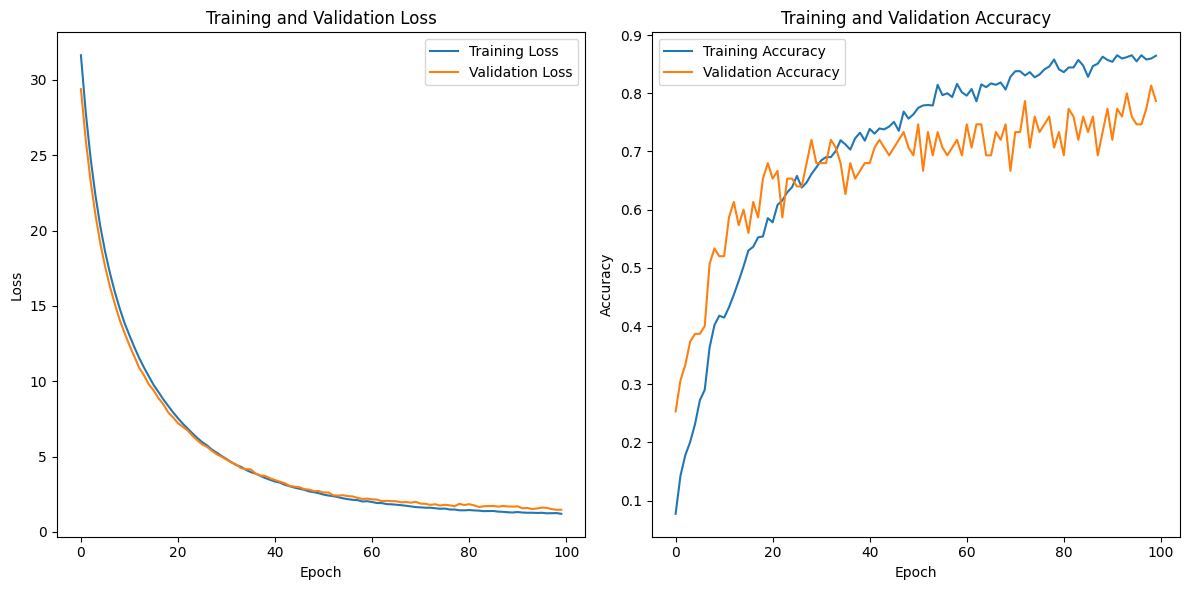

In [15]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res17.history['loss'], label='Training Loss')
plt.plot(res17.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res17.history['accuracy'], label='Training Accuracy')
plt.plot(res17.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 14th attempt 

Este otimizador voltou a apresentar um comportamento mais satisfatório, sendo que a forma como este modelo generaliza os dados continua a não apresentar melhorias.

## Attempt 15

### CNN Architecture

* Step 1: 1st convolutional layer:
  * **shape (128, 128, 3);**
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd covolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* **Step 5: 3rd convolutional layer:**
  * **filters (64);**
  * **kernel_size (3);**
  * **BatchNormalization;**
  * **activation function (Relu);**
* **Step 6: 3rd max pooling:** 
  * **pool_size = 2;** 
  * **strides = 2;** 
  * **dropout (0.30);** 
* Step 7: Flattening
* Step 8: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * dropout (0.30);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.40);
* Step 9: Output layer:
  * units (15);
  * activation function (softmax);
* Step 10: Optimizer:
  * **Adam**;
  * **Learning_rate (0.00005)**; 
  * weight_decay (0.03);

**Epochs: 100**

**Aumentado tamanho das imagens. Aumentado o conjunto de convolutional layers para 3**

In [7]:
train_datagen18 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set18 = train_datagen18.flow_from_directory('train_set',
                                                 target_size = (128, 128), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen18 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set18 = test_datagen18.flow_from_directory('test_set',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn18 = tf.keras.models.Sequential()

cnn18.add(tf.keras.layers.Input(shape=[128, 128, 3]))


cnn18.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn18.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn18.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn18.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn18.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%

cnn18.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn18.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn18.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%


cnn18.add(tf.keras.layers.Flatten())


cnn18.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn18.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%
cnn18.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn18.add(tf.keras.layers.Dropout(0.40))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn18.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn18.summary()


cnn18.compile(optimizer=Adam(learning_rate=0.00005, weight_decay=0.03, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])


res18 = cnn18.fit(x = training_set18, validation_data = test_set18, epochs = 100)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 27, 27, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,896,655 (11.05 MB)

 Trainable params: 2,896,655 (11.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 310ms/step - accuracy: 0.0774 - loss: 34.4340 - val_accuracy: 0.1200 - val_loss: 32.0761
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.0694 - loss: 31.8099 - val_accuracy: 0.1200 - val_loss: 30.3622
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.0894 - loss: 29.9191 - val_accuracy: 0.1467 - val_loss: 28.4083
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.0889 - loss: 27.9786 - val_accuracy: 0.1733 - val_loss: 26.6202
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - accuracy: 0.0760 - loss: 26.1973 - val_accuracy: 0.1467 - val_loss: 24.8501
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.0683 - loss: 24.4891 - val_accuracy: 0.1600 - val_loss: 23.2747
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - accuracy: 0.1166 - loss: 22.9232 - val_accuracy: 0.1600 - val_loss: 21.8666
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 283ms/step - accuracy: 0.1373 - l

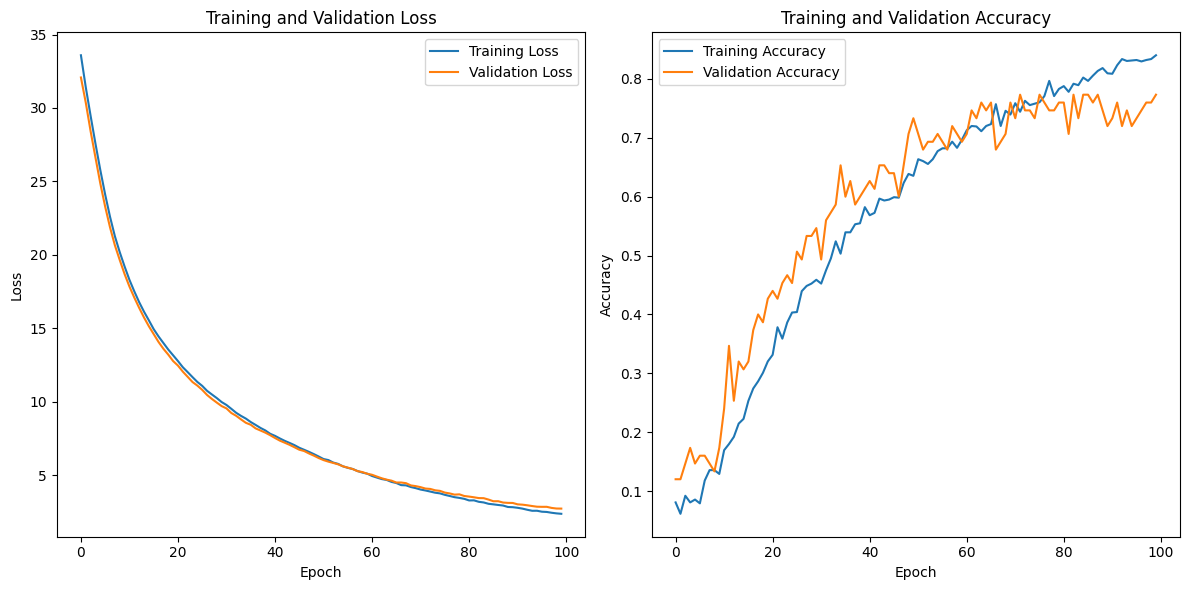

In [8]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res18.history['loss'], label='Training Loss')
plt.plot(res18.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res18.history['accuracy'], label='Training Accuracy')
plt.plot(res18.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Conclusion 15th attempt 



Nesta attempt podemos ver que o modelo teve um pior desempenho. No gráfico da Accuracy nota-se um crescimento lento e instável de ambas as curvas. Para além disso, os valores da loss function são mais elevados do que o pretendido.

# Conclusion

Concluimos que o modelo com melhor desempenho foi o executado na attempt 14, devido à curva da loss function e à curva da accuracy. Desta forma, de seguida, o código da attempt 14 é corrido novamente mas apenas para 40 epochs. 

## Attempt 14

### CNN Architecture

* Step 1: 1st convolutional layer:
  * shape (64, 64, 3);
  * filters (32);
  * kernel_size (5);
  * BatchNormalization;
  * activation function (Relu);
* Step 2: 1st first max pooling: 
  * pool_size = 5;
  * strides = 2;
* Step 3: 2nd convolutional layer:
  * filters (64);
  * kernel_size (3);
  * BatchNormalization;
  * activation function (Relu);
* Step 4: 1st first max pooling: 
  * pool_size = 2;
  * strides = 2;
  * dropout (0.25);
* Step 5: Flattening
* Step 6: Full connection (2 layers):
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer
  * dropout (0.30);
  * units (256);
  * activation function (Relu);
  * L2 regularization (0.03);
  * He Initializer:
  * dropout (0.40);
* Step 7: Output layer:
  * units (15);
  * activation function (softmax);
* Step 8: Optimizer:
  * AdamW**;
  * Learning_rate (0.0001); 
  * weight_decay (0.03);
  * eliminated rho (0.9);
  * eliminated momentum (0.0);

**Epochs: 40**

In [46]:
train_datagen19 = ImageDataGenerator(rescale = 1./255, # features scalling - all the pixels values wiil be between 0 and 1
                                   shear_range = 0.2, # geometric transformation
                                   zoom_range = 0.2, # zoom
                                   horizontal_flip = True) # flip

# apply the augmentation considering our original train images
training_set19 = train_datagen19.flow_from_directory('train_set',
                                                 target_size = (64, 64), # final size of the images
                                                 batch_size = 32, # images for each batch
                                                 class_mode = 'categorical') # our classification problem

test_datagen19 = ImageDataGenerator(rescale = 1./255) # we only apply the rescale transformation

test_set19 = test_datagen19.flow_from_directory('test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

cnn19 = tf.keras.models.Sequential()

cnn19.add(tf.keras.layers.Input(shape=[64, 64, 3]))


cnn19.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', kernel_initializer=HeNormal()))
cnn19.add(tf.keras.layers.MaxPool2D(pool_size=5, strides=2))


cnn19.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=HeNormal()))
cnn19.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn19.add(tf.keras.layers.Dropout(0.25))  # Add a dropout layer with a dropout rate of 25%


cnn19.add(tf.keras.layers.Flatten())


cnn19.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn19.add(tf.keras.layers.Dropout(0.30))  # Add a dropout layer with a dropout rate of 25%
cnn19.add(tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()))
cnn19.add(tf.keras.layers.Dropout(0.40))  # Add a dropout layer with a dropout rate of 25%


#cnn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
cnn19.add(tf.keras.layers.Dense(units=15, activation='softmax'))



# Visualize the CNN
cnn19.summary()


cnn19.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=0.03), loss='categorical_crossentropy', metrics=['accuracy'])


res19 = cnn19.fit(x = training_set19, validation_data = test_set19, epochs = 40)

Found 1240 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,859,727 (10.91 MB)

 Trainable params: 2,859,727 (10.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.0551 - loss: 33.1275 - val_accuracy: 0.1067 - val_loss: 29.8947
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.0792 - loss: 29.1394 - val_accuracy: 0.1333 - val_loss: 26.7997
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.1211 - loss: 26.1357 - val_accuracy: 0.2133 - val_loss: 24.1312
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.1328 - loss: 23.6652 - val_accuracy: 0.1733 - val_loss: 22.0185
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.1353 - loss: 21.5977 - val_accuracy: 0.2533 - val_loss: 20.1336
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.1612 - loss: 19.8331 - val_accuracy: 0.2133 - val_loss: 18.6061
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.1883 - loss: 18.2924 - val_accuracy: 0.2400 - val_loss: 17.2575
Epoch 8/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.2276 - loss: 16.9567 - v

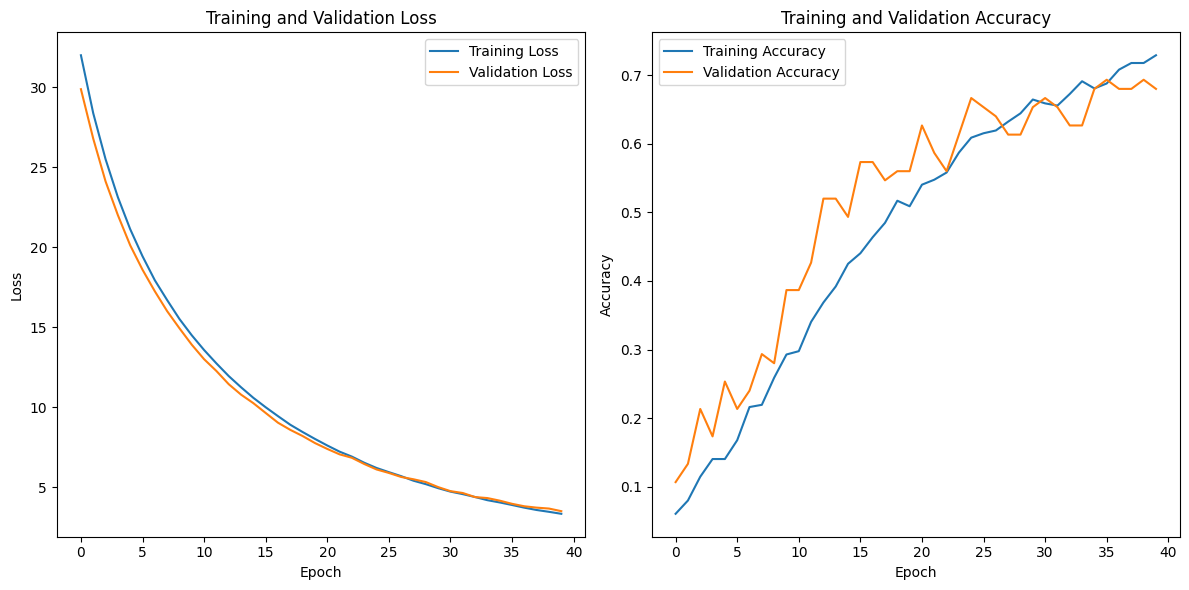

In [47]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(res19.history['loss'], label='Training Loss')
plt.plot(res19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(res19.history['accuracy'], label='Training Accuracy')
plt.plot(res19.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step 


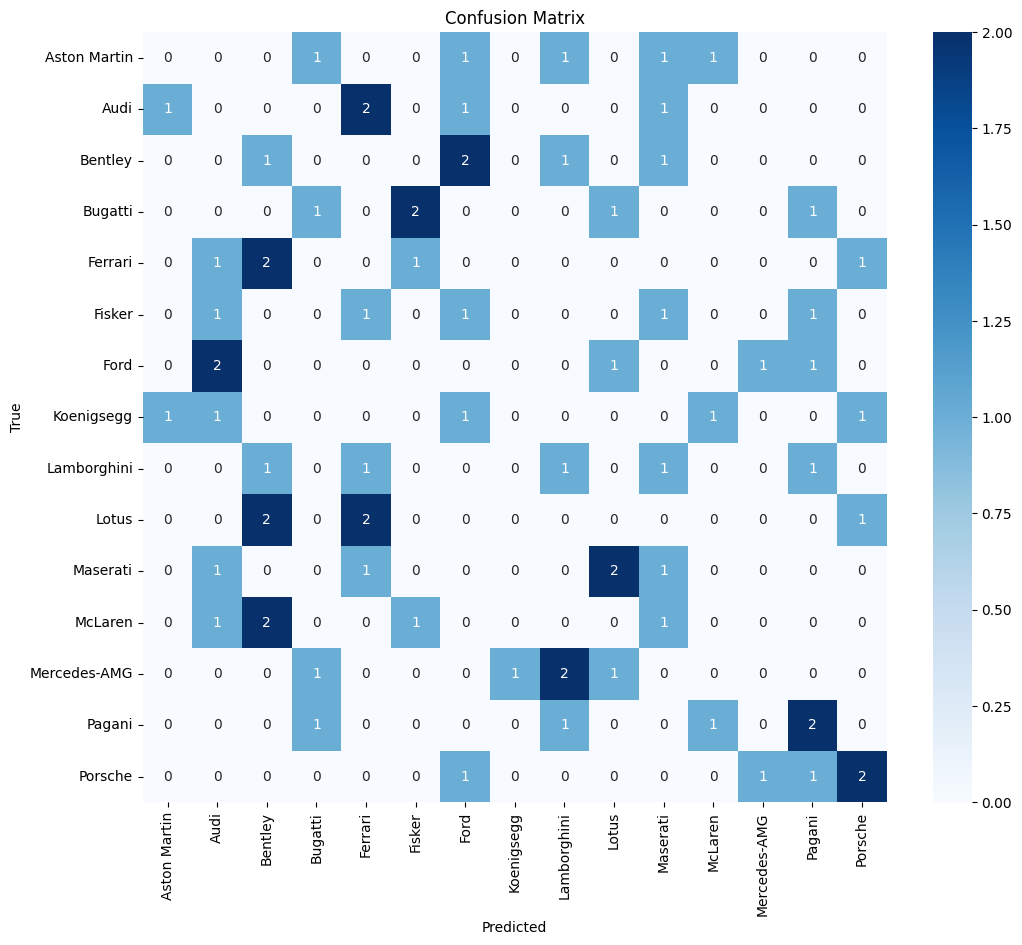

              precision    recall  f1-score   support

Aston Martin       0.00      0.00      0.00         5
        Audi       0.00      0.00      0.00         5
     Bentley       0.12      0.20      0.15         5
     Bugatti       0.25      0.20      0.22         5
     Ferrari       0.00      0.00      0.00         5
      Fisker       0.00      0.00      0.00         5
        Ford       0.00      0.00      0.00         5
  Koenigsegg       0.00      0.00      0.00         5
 Lamborghini       0.17      0.20      0.18         5
       Lotus       0.00      0.00      0.00         5
    Maserati       0.14      0.20      0.17         5
     McLaren       0.00      0.00      0.00         5
Mercedes-AMG       0.00      0.00      0.00         5
      Pagani       0.29      0.40      0.33         5
     Porsche       0.40      0.40      0.40         5

    accuracy                           0.11        75
   macro avg       0.09      0.11      0.10        75
weighted avg       0.09   

In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
validation_predictions = cnn19.predict(test_set)
predicted_classes = np.argmax(validation_predictions, axis=1)  # Get predicted class indices
true_classes = test_set.classes  # Get ground truth class indices

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
class_labels = list(test_set.class_indices.keys())  # Retrieve class labels

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

A análise da matriz de confusão permite tirar vários insights do modelo CNN da attempt 14. Podemos verificar que há uma confusão significativa entre várias marcas, isto porque pode haver uma dificuldade por parte do modelo em diferenciar marcas com logos semelhantes. No entanto, também podemos reparar que para as marcas Bentley, Bugatti, Lamborghini, Maserati, Pagani e Porsche, o modelo conseguiu prever corretamente 50% das vezes ou mais (Pagani e Porsche).

Concluímos que, para além do modelo apresentar uma accuracy de 74% no treino e 68% no teste, ainda era possível melhorá-lo para obter valores de previsão mais precisos. Para isso poderíamos tentar as seguintes abordagens:
* Aumentar o dataset;
* Adicionar mais transformações às imagens do dataset;
* Testar novos hiperparâmetros;